In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re

In [13]:
df = pd.read_csv("Categorized_Adversary_TTPs.csv") # sample dataset of attacks
df.head()

,mitre_attack_id,mitre_attack_name,mitre_attack_aliases,mitre_attack_created,mitre_attack_last_modified,etda_id,etda_name,etda_aliases,etda_first_seen,country,motivation,victim_industries,victim_countries,mitre_attack_ttps
0,intrusion-set--dc5e2999-ca1a-47d4-8d12-a6984b1...,UNC2452,"['UNC2452', 'NOBELIUM', 'StellarParticle', 'Da...",2021-01-05,2021-05-04,93ba9804-335e-4782-855d-40af22b93201,"APT 29, Cozy Bear, The Dukes","['APT 29', 'Cozy Bear', 'The Dukes', 'Group 10...",2008,RU,['Information theft and espionage'],"['Defense', 'Energy', 'Government', 'Law enfor...","['Australia', 'Azerbaijan', 'Belarus', 'Belgiu...","['T1484.002', 'T1071.001', 'T1053.005', 'T1036..."
1,intrusion-set--8f5e8dc7-739d-4f5e-a8a1-a66e004...,Cleaver,"['Cleaver', 'Threat Group 2889', 'TG-2889']",2017-05-31,2021-10-12,4622bc44-8c01-4807-8d12-b22352472c29,"Cutting Kitten, TG-2889","['Cutting Kitten', 'TG-2889', 'Operation “Clea...",2012,IR,['Information theft and espionage'],"['Aerospace', 'Aviation', 'Chemical', 'Defense...","['Canada', 'China', 'France', 'Germany', 'Indi...","['T1588.002', 'T1003.001', 'T1587.001', 'T1585..."
2,intrusion-set--0ea72cd5-ca30-46ba-bc04-378f701...,GCMAN,['GCMAN'],2017-05-31,2020-03-30,e6eeb30a-a941-46f9-8340-20958f1d6cb0,GCMAN,['GCMAN'],2016,RU,['Financial crime'],['Financial'],['Russia'],"['T1021.005', 'T1021.004']"
3,intrusion-set--dd2d9ca6-505b-4860-a604-233685b...,Wizard Spider,"['Wizard Spider', 'UNC1878', 'TEMP.MixMaster',...",2020-05-12,2021-10-14,480940e0-47b0-4295-9067-c2500ccfdaec,"Wizard Spider, Gold Blackburn","['Wizard Spider', 'Grim Spider', 'TEMP.MixMast...",2014,RU,"['Financial crime', 'Financial gain']","['Defense', 'Financial', 'Government', 'Health...",None Provided,"['T1053.005', 'T1033', 'T1070.004', 'T1059.003..."
4,intrusion-set--f9d6633a-55e6-4adc-9263-6ae0804...,Magic Hound,"['Magic Hound', 'TA453', 'COBALT ILLUSION', 'C...",2018-01-16,2022-04-17,bb9b25ed-9ddc-4f65-bd01-ab8d6efc34ac,"Magic Hound, APT 35, Cobalt Gypsy, Charming Ki...","['Magic Hound', 'APT 35', 'Cobalt Illusion', '...",2012,IR,['Information theft and espionage'],"['Defense', 'Energy', 'Financial', 'Government...","['Afghanistan', 'Canada', 'Egypt', 'Iran', 'Ir...","['T1071', 'T1564.003', 'T1560.001', 'T1586.002..."


In [14]:
from pyattck import Attck

attack = Attck()

#dictionary for high speed access
actors = {}
for actor in attack.enterprise.actors:
    actors[actor.id] = actor
malwares = attack.enterprise.malwares + attack.enterprise.tools
ttpLists = []
for malware in malwares:
    ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

In [15]:
# to use the apriori we need to generate a list of lists
aprList = []
for row in df.values:
    aprList.append((row[13].strip('][').split(', ')))

In [16]:
aprList += ttpLists
len(aprList)

746

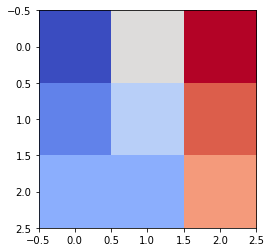

In [17]:
import matplotlib.pyplot as plt

# Your list of lists of confidence values
confidences = [[0.1, 0.5, 0.9], [0.2, 0.4, 0.8], [0.3, 0.3, 0.7]]

plt.imshow(confidences, cmap='coolwarm')
plt.show()

In [18]:
# calculate the support of a ttp value where data is a list of lists and ttps is a list of ttps
def calculateSupport(ttps, data):
    count = sum([1 for l in data if set(ttps).issubset(set(l))])
    support = count/len(data)
    return support


calculateSupport(["'T1566.002'", "'T1204.002'"], aprList)

0.06166219839142091

In [19]:
# calculates the confidence of 1:1 rule where data is a list of lists
# anticedant and consequent are lists such that anticedant -> consequent
def calculateConfidence(anticedant, consequent, data):
    return calculateSupport(anticedant+consequent, data)/calculateSupport(anticedant, data)

calculateConfidence(["'T1566.002'"], ["'T1204.002'"], aprList)

0.8214285714285715

In [20]:
# loop through set of all TTPs
from tqdm import tqdm
ttps = list(set([item for sublist in aprList for item in sublist]))

confidenceMatrix = [[0]*len(ttps)]*len(ttps)
supportMatrix = [[0]*len(ttps)]*len(ttps)
for i in tqdm(range(0, len(ttps))):
    for j in range(0, len(ttps)):
        confidenceMatrix[i][j] = calculateConfidence([ttps[i]], [ttps[j]], aprList)

100%|████████████████████████████████████████████████████████████████████████████████| 481/481 [04:34<00:00,  1.75it/s]


In [22]:
#confidenceMatrix